# Example 2: Detecting the age-oxygen correlation

In Section 7 of [Bixel & Apai (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....161..228B/abstract) (and in [Bixel & Apai 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...896..131B/abstract)), we propose that Earth-like planets might have similar atmospheric evolution to Earth's, i.e. toward greater biogenic oxygen content over Gyr timescales. If so, this would imply a positive "age-oxygen correlation" between the fraction of Earth-like planets with atmospheric oxygen and their ages.

In this example, you will use Bioverse to determine whether a [Nautilus](https://ui.adsabs.harvard.edu/abs/2019AJ....158...83A/abstract)-like transit spectroscopy survey could test this hypothesis.

## Setup

We will begin by importing modules from Bioverse

In [1]:
# Import the relevant modules
from bioverse.survey import TransitSurvey
from bioverse.generator import Generator
from bioverse.hypothesis import Hypothesis
from bioverse import analysis, plots


# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20.

In this example, we will use the simulator for a transit spectroscopy survey with an effecting diameter of 50 meters.

In [2]:
generator = Generator('transit')
survey = TransitSurvey('default')

## Injecting the statistical effect

We propose that the fraction of Earth-like planets with oxygen-rich atmospheres should increase over Gyr timescales. We can simulate this in Bioverse using a function with two parameters:

- `f_life`: the fraction of exo-Earth candidates with life

- `t_half`: the "half-life" timescale over which inhabited planets become oxygenated

Let's define a function and append it to the generator.

In [3]:
def oxygen_evolution(d, f_life=0.8, t_half=3.):
    # First, assign no O2 to all planets
    d['has_O2'] = np.zeros(len(d))

    # Calculate the probability that each EEC has O2 based on its age
    EEC = d['EEC']
    P = f_life * (1 - 0.5**(d['age'][EEC]/t_half))

    # Randomly assign O2 to some EECs
    d['has_O2'][EEC] = np.random.uniform(0, 1, EEC.sum()) < P

    return d

generator.insert_step(oxygen_evolution)

Next, we can simulate a dataset and investigate the relationship between the ages and oxygen content of EECs. For now, we assume `f_life` = 80% and `t_half` = 3 Gyr.

Note that the transit survey is more readily capable of detecting ozone than O2, as it has broader and deeper absorption bands and mostly resides above the cloud deck. We assume O3 is a reliable proxy for O2.

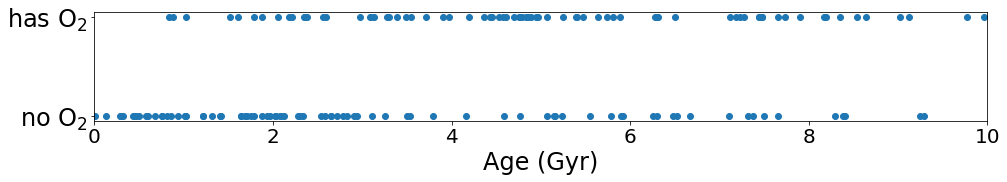

In [4]:
# Create the planet sample
sample, detected, data = survey.quickrun(generator, f_life=0.8, t_half=3., t_total=10*365.25)

# Extract measured ages and the presence of oxygen
x, y = data['age'], data['has_O2']

# Now plot the oxygen-rich/oxygen-poor planets versus age
fig, ax = plt.subplots(figsize=(16, 2))
ax.scatter(x, y)
ax.set_yticks([0, 1])
ax.set_xlim([0,10])
ax.set_yticklabels(['no O$_2$','has O$_2$'],fontsize=24)
ax.set_xlabel('Age (Gyr)',fontsize=24)

plt.show()

As in Example 1, the expected trend appears to be present i.e. the presence of oxygen (via its proxy ozone) appears to correlate with age. But is this trend statistically significant?

## Defining the hypothesis

To answer this, we will define a new Hypothesis. The functional form of this hypothesis will be the same as above i.e. a two-parameter decay rate function. As in the previous example, we must specify the names of the hypothesis parameters, independent variable (`age`), and dependent variable (`has_O2`) in the function signature. We again select log-uniform prior distributions for the two parameters:

0.01 < `f_life` < 1

0.3 < `t_half` < 30 Gyr

In [5]:
def f(theta:('f_life', 't_half'), X:('age',)) -> ('has_O2',):
    f_life, t_half = theta
    return f_life * (1-0.5**(X/t_half))

bounds = np.array([[0.01, 1], [0.3, 30]])
h_age_oxygen = Hypothesis(f, bounds, log=(True, True))

We also need to define the null hypothesis, which states that the fraction of planets with O2 is (log-uniform) random between 0.001 to 1 and independent of age:

In [6]:
def f_null(theta:('f_O2',), X:('age',)) -> ('has_O2',):
    shape = (np.shape(X)[0], 1)
    return np.full(shape, theta)

bounds_null = np.array([[0.001, 1.]])
h_age_oxygen.h_null = Hypothesis(f_null, bounds_null, log=(True,))

We can calculate the Bayesian evidence supporting `h_age_oxygen` in favor of `h_null` from our simulated dataset.

In [7]:
results = h_age_oxygen.fit(data)
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.1E})".format(results['dlnZ'], np.exp(-results['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 13.7 (corresponds to p = 1.1E-06)


The default nested sampling test reveals some compelling evidence in favor of the hypothesis, but it may not be the most efficient test for this problem.

We can also use the Mann-Whitney U test to determine whether the typical age of planets with oxygen-rich atmospheres is higher than that of oxygen-poor planets. This test should be more sensitive, as it makes no specific assumptions about the functional form of the correlation (i.e. `func` defined above is not used).

In [8]:
results = h_age_oxygen.fit(data, method='mannwhitney')
print('Correlation detected with p = {:.1E} significance'.format(results['p']))

Correlation detected with p = 1.5E-06 significance


Typically, the Mann-Whitney test detects the correlation with even greater significance (i.e. lower p-values)

**Note for iPython/Jupyter users:** We will need to reload the `generator` and `h_age_oxygen` objects here to replace the ones you have defined above. These will produce the same results, but the next code block uses the `multiprocessing` module which is incompatible with functions defined in iPython.

In [9]:
generator = Generator('transit')
from bioverse.hypothesis import h_age_oxygen

## Computing statistical power

Thus far, we have assumed the fraction of planets with life to be `f_life` = 80% and `t_half` = 3 Gyr. If fewer planets are inhabited, or if the evolutionary timescale is much longer than the maximum ages probed (~10 Gyr), then the correlation will be more difficult to detect. Let's test the sensitivity of our results to both of these parameters simultaneously using the `test_hypothesis_grid` function.

Once again, we will use the more sensitive Mann-Whitney test to determine whether the correlation exists. This may take up to ten minutes - reduce `N_grid` for quicker results.

In [10]:
N_grid = 8
f_life = np.logspace(-1, 0, N_grid)
t_half = np.logspace(np.log10(0.5), np.log10(50), N_grid)
results = analysis.test_hypothesis_grid(h_age_oxygen, generator, survey, method='mannwhitney', f_life=f_life, t_half=t_half, N=20, processes=8, t_total=10*365.25)

100%|██████████| 1280/1280 [06:36<00:00,  3.23it/s]


Now, we will use the `plot_power_grid()` function of the `plots` module to plot the statistical power of the survey (i.e. the fraction of tests achieving p < 0.05 significance) versus both parameters.

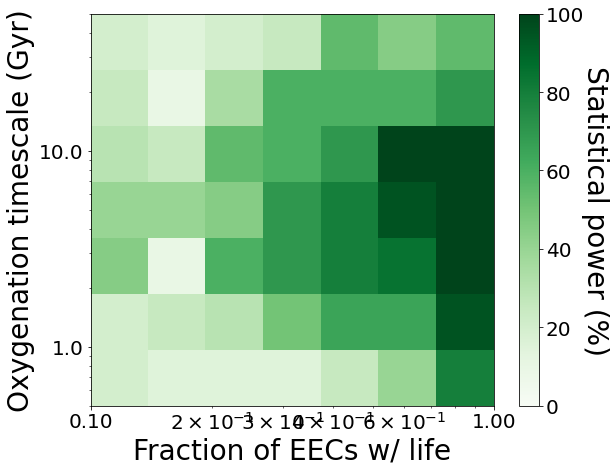

In [11]:
plots.plot_power_grid(results, method='p', axes=('f_life', 't_half'), labels=('Fraction of EECs w/ life', 'Oxygenation timescale (Gyr)'), log=(True, True), levels=None)

The "sweet spot" where high statistical power is achieved is where life is common (`f_life` > 50%) and the oxygenation timescale falls within ~2-10 Gyr.

We can also investigate the survey's sensitivity as a function of total survey time. Let's try values from 0.1 to 10 years, assuming `f_life` = 50% and `t_half` = 3 Gyr. This will take a few minutes.

In [12]:
t_total = np.logspace(-1, 1, 10) * 365.25
results = analysis.test_hypothesis_grid(h_age_oxygen, generator, survey, method='mannwhitney', f_life=0.5, N=20, processes=8, t_total=t_total)

100%|██████████| 200/200 [01:01<00:00,  3.25it/s]


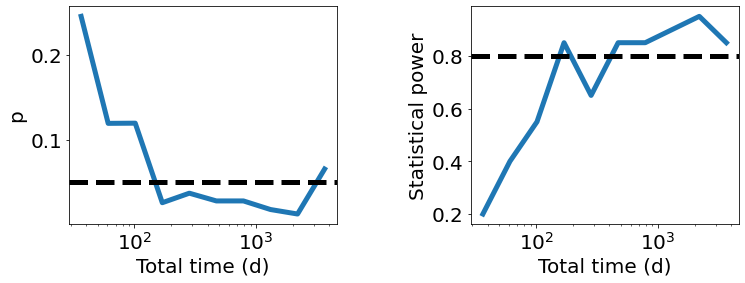

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(t_total, results['p'].mean(axis=-1), lw=5)
ax[0].set_xlabel('Total time (d)', fontsize=20)
ax[0].set_ylabel('p', fontsize=20)
ax[0].axhline(0.05, lw=5, c='black', linestyle='dashed')
ax[0].set_xscale('log')

power = analysis.compute_statistical_power(results, method='p', threshold=0.05)
ax[1].plot(t_total, power, lw=5)
ax[1].set_xlabel('Total time (d)', fontsize=20)
ax[1].set_ylabel('Statistical power', fontsize=20)
ax[1].axhline(0.8, lw=5, c='black', linestyle='dashed')
ax[1].set_xscale('log')

plt.subplots_adjust(wspace=0.5)

Approximately 1-2 years will be required to detect the correlation under these assumptions.